In [1]:
import pandas as pd

# Loading the comments dataset
comments_df = pd.read_csv("comments.csv")

In [2]:
df = pd.read_csv("comment_sample.csv")
label_counts = df["Label"].value_counts()

print(label_counts)

Label
2    151
0     77
1     72
Name: count, dtype: int64



### Sample Labeling for Testing

In preparation for testing my fine-tuned DistilBERT model, I manually labeled a sample of 300 YouTube comments. The labeling process involved categorizing comments into three sentiment classes: 2 for neutral, 1 for positive, and 0 for negative. However, as the model was fine-tuned specifically for positive and negative sentiment analysis, I plan to remove the neutral class during evaluation to focus on the target sentiments.

The positive and negative sentiment classes turned out to be randomly distributed, with approximately equal weighting. In the sample, there were 72 positive comments and 77 negative comments, while the remaining comments were labeled as neutral. This labeled sample will be used to assess the model's performance on YouTube comments, providing valuable insights into its ability to classify sentiments effectively.

In [3]:
df_test = df.drop(columns="Comment ID")

df_test = df_test[df_test["Label"] != 2]

df_test.head()

,Comment,Label
5,You guys are clueless about buyers agents. The...,0
7,This guy sounds like ChatGpt wrote him 😂,0
10,"These woke, sorry “red pill” takers, are going...",0
12,Jcal is killing it lately lol🤣,1
15,I love you JCAL!!,1


In [4]:
import pandas as pd

df_test["Comment"] = df_test["Comment"].astype(str)

# Preprocess the "Comment" column in one line:
df_test["Comment"] = df_test["Comment"].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip().str.replace(r"\s+", " ", regex=True)

In [5]:
import tensorflow as tf
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Extracting the comments from the test dataset
youtube_comments = df_test["Comment"].tolist()

# Tokenizing the YouTube comments using the same tokinzer
tokenized_youtube_comments = tokenizer(
    youtube_comments,
    padding=True,
    truncation=True,
    max_length=103,
    return_tensors="tf"
)

# Extracing input IDs and attenetion mask for the test dataset
input_ids_test = tokenized_youtube_comments["input_ids"]
attention_mask_test = tokenized_youtube_comments["attention_mask"]

# Adding tokenized data to the original DataFrame for the test dataset
df_test["input_ids"] = input_ids_test.numpy().tolist()
df_test["attention_mask"] = attention_mask_test.numpy().tolist()

C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df_test.head()

df_test.to_csv("../Youtube_comment_scraper/df_test.csv", index=False)

In [7]:
import numpy as np

input_ids_test = df_test["input_ids"].tolist()
attention_mask_test = df_test["attention_mask"].tolist()

# Converting lists to NumPy arrays for YouTube comment data
input_ids_array = np.array(input_ids_test)
attention_mask_array = np.array(attention_mask_test)

# "Label" containts the ground truth for the YouTube comment data
label_test = df_test["Label"].values

# Creating a dictionary for YouTube comment data
test_data_np = {
    "input_ids": input_ids_array,
    "attention_mask": attention_mask_array
}

# Creating a TensorFlow dataset for the YouTube comment data
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_np, label_test))

# Batching the YouTube comment data
test_dataset = test_dataset.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [8]:
from transformers import TFDistilBertModel

model_path = "../NLP_model/best_sentiment_model.keras"

# Loading the best model from local directory
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={"TFDistilBertModel": TFDistilBertModel}
)

C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [10]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 103)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 103)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 103, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                       

The fine-tuned DistilBERT model, specifically trained for binary sentiment classification, is then loaded, retaining its task-specific configuration. This enables the model to predict sentiment based on its training with similar data.

In the subsequent sections, the loaded DistilBERT model is applied to predict sentiment in the prepared YouTube comments. The analysis aims to reveal insights into the model's effectiveness in discerning sentiment within the context of user-generated content on the YouTube platform.

In [11]:
# Checking wheather the weights have been loaded correctly
for layer in loaded_model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)

tf_distil_bert_model/distilbert/embeddings/word_embeddings/weight:0 (30522, 768)
tf_distil_bert_model/distilbert/embeddings/position_embeddings/embeddings:0 (512, 768)
tf_distil_bert_model/distilbert/embeddings/LayerNorm/gamma:0 (768,)
tf_distil_bert_model/distilbert/embeddings/LayerNorm/beta:0 (768,)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/q_lin/kernel:0 (768, 768)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/q_lin/bias:0 (768,)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/k_lin/kernel:0 (768, 768)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/k_lin/bias:0 (768,)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/v_lin/kernel:0 (768, 768)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/v_lin/bias:0 (768,)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/out_lin/kernel:0 (768, 768)
tf_distil_bert_model/distilbert/transformer/layer_._0/attention/out_lin/bias:0 (768

In [13]:
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Making predictions on the YouTube dataset
predictions_test = loaded_model.predict(test_dataset)

# Getting the predicted values (1 if probability >= 0.5, else 0)
predicted_labels = (predictions_test >= 0.5).astype(int)

print("Predicted Labels for the YouTube comment dataset:", predicted_labels.flatten())

5/5 [==============================] - 5s 643ms/step
Predicted Labels for the YouTube comment dataset: [0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1
 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1
 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1
 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0
 0]


In [13]:
test_loss, test_accuracy = loaded_model.evaluate(test_dataset, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



5/5 - 6s - loss: 0.4484 - accuracy: 0.8792 - 6s/epoch - 1s/step
Test Loss: 0.4484, Test Accuracy: 0.8792


In [15]:
predicted_labels_flat = tf.reshape(predicted_labels, [-1])

y, idx, count = tf.unique_with_counts(predicted_labels_flat)

# Printing label counts
for label, count in zip(y.numpy(), count.numpy()):
    print(f"Label {label}: {count} occurences")

Label 0: 77 occurences
Label 1: 72 occurences


## Model Evaluation and Advanced Metrics Implementation

In this section, we will enhance our understanding of the model's performance by implementing a range of additional evaluation metrics. While the accuracy metric provides a general sense of how often our model predicts correctly, it does not tell the whole story, especially in the context of binary classification tasks like sentiment analysis. To gain deeper insights, we will calculate and review the following metrics:

- **Precision**: This metric will help us understand the proportion of positive identifications that were actually correct. It is particularly important in scenarios where the cost of false positives is high.

- **Recall**: Also known as sensitivity, recall gives us the proportion of actual positives that were correctly identified. This metric is crucial when the cost of false negatives is significant.

- **F1 Score**: As a harmonic mean of precision and recall, the F1 score provides a single metric that balances both false positives and false negatives, which is useful when we seek a balance between precision and recall.

- **ROC-AUC Score**: The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) provide insights into the model's performance across various threshold settings. The ROC-AUC score is especially useful for evaluating the model's ability to distinguish between the classes.

- **Confusion Matrix**: This matrix will allow us to visualize the model's predictions, offering a clear picture of the classification done by the model, including true positives, true negatives, false positives, and false negatives.

By analyzing these metrics, we will be able to understand not just how often the model is correct on average (accuracy), but also how it behaves in terms of different types of errors (false positives and false negatives). This comprehensive analysis is crucial for determining the practical applicability of our sentiment analysis model and for planning subsequent steps to improve its performance.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

true_labels = label_test
predicted_labels = (predictions_test >= 0.5).astype(int)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predictions_test)  # Use raw probabilities for ROC-AUC

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Precision: 0.8750
Recall: 0.8750
F1 Score: 0.8750
ROC-AUC Score: 0.9511


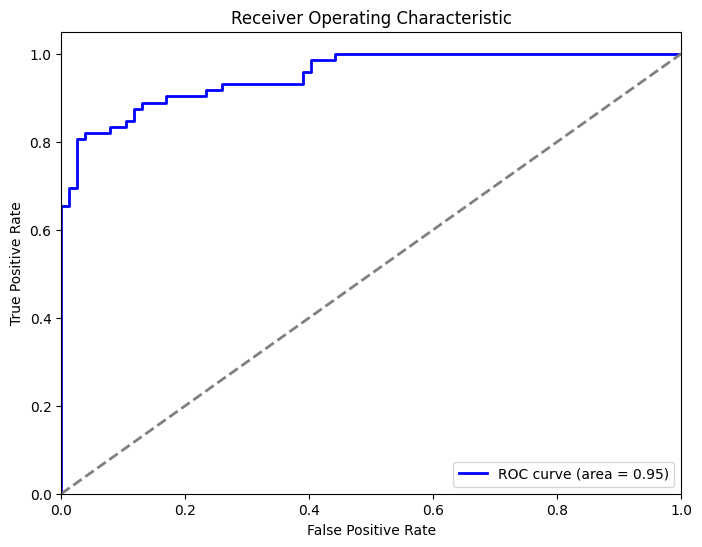

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, tresholds = roc_curve(label_test, predictions_test)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Analysis of Misclassified Samples

Having evaluated our sentiment analysis model and identified areas of high accuracy, we will now delve deeper into instances where the model did not perform as expected. The aim is to scrutinize the misclassified samples to gain a better understanding of the model's limitations and the types of sentiment expressions it struggles to interpret correctly.

This examination will involve a careful review of the text of misclassified comments, comparing the predicted sentiments against the true labels. By identifying patterns or commonalities among these inaccuracies, we can uncover valuable insights into:

- The linguistic nuances and contextual subtleties that the model may be overlooking.
- Specific instances of language use, such as sarcasm, idioms, or domain-specific jargon, that may be leading to incorrect classifications.
- Potential preprocessing or feature engineering improvements that could enhance the model's ability to capture and classify sentiments more accurately.

The ultimate goal of this analysis is to iteratively refine our model and preprocessing techniques to improve its performance on complex, real-world data and ensure that it generalizes well to the types of sentiment expressions it will encounter in practice.

In [19]:
predicted_labels = (predictions_test >= 0.5).astype(int).flatten()

true_labels = label_test.flatten()

misclasified_indices = np.where(predicted_labels != true_labels)[0]

misclasified_samples = df_test.iloc[misclasified_indices]

misclasified_probabilities = predictions_test[misclasified_indices]

misclasified_df = misclasified_samples.assign(
    predicted_probability = misclasified_probabilities,
    predicted_label = predicted_labels[misclasified_indices]
)

misclasified_df.head(20)

,Comment,Label,input_ids,attention_mask,predicted_probability,predicted_label
7,this guy sounds like chatgpt wrote him,0,"[101, 2023, 3124, 4165, 2066, 11834, 21600, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",0.716375,1
12,jcal is killing it lately lol,1,"[101, 29175, 2389, 2003, 4288, 2009, 9906, 884...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",0.107166,0
23,as elon tells the advert bribers to go f thems...,1,"[101, 2004, 3449, 2239, 4136, 1996, 4748, 1687...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.004524,0
35,what about a show where you analyse your own c...,0,"[101, 2054, 2055, 1037, 2265, 2073, 2017, 2030...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.869806,1
60,great interview with tuckerwhat the failure of...,1,"[101, 2307, 4357, 2007, 9802, 2860, 12707, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.002868,0
69,so if we are laughing at ideas let me throw th...,0,"[101, 2061, 2065, 2057, 2024, 5870, 2012, 4784...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.690708,1
125,again i would have been open to hearing a more...,0,"[101, 2153, 1045, 2052, 2031, 2042, 2330, 2000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.991983,1
165,subsidies are going to unions that fund biden ...,0,"[101, 21762, 2024, 2183, 2000, 9209, 2008, 463...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.922473,1
175,more beeps than morse code last time,0,"[101, 2062, 10506, 4523, 2084, 17107, 3642, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",0.918181,1
176,tucker is the man,1,"[101, 9802, 2003, 1996, 2158, 102, 0, 0, 0, 0,...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.260404,0
